In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/training-data-cfm/X_test_m4HAPAP.csv
/kaggle/input/training-data-cfm/y_train_or6m3Ta.csv
/kaggle/input/training-data-cfm/X_train_N1UvY30.csv
/kaggle/input/execdataanalysis/DATA_ANALYSIS.py
/kaggle/input/execdataanalysis/DATA_SIMPLE_MODEL.py
/kaggle/input/execdataanalysis/__init__.py
/kaggle/input/optimization-cfm/small_X_test.csv
/kaggle/input/optimization-cfm/small_X_train.csv
/kaggle/input/optimization-cfm/small_y_train.csv


In [2]:
import sys
sys.path.append("/kaggle/input/execdataanalysis")

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import os 

from DATA_ANALYSIS import load_data
from DATA_SIMPLE_MODEL import train_lgb_get_importance, aggregate_sequences, permutation_importance_on_model, shap_importance 

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder


import numpy as np
import pandas as pd
from scipy.stats import skew

import numpy as np
import pandas as pd
from scipy.stats import skew

# --- Fonction log transform stable ---
def log_transform(X):
    X = np.array(X, dtype=np.float64)
    X[~np.isfinite(X)] = np.nan
    X = np.nan_to_num(X, nan=0.0)
    return np.sign(X) * np.log(np.abs(X) + 1)

# --- Fonction principale ---
def add_feature_engineering(
    df: pd.DataFrame,
    test: bool = False,
    list_test=None,
    use_microstructure=True,
    use_imbalance=True,
    use_price_dynamics=True,
    use_momentum=True,
    momentum_windows=[3, 5, 10, 20, 40],
    use_flux=True,
    use_directional=True,
    use_log=True,
    corr_threshold=0.7
):
    if list_test is None:
        list_test = []

    base_cols = ['venue', 'order_id', 'action', 'side', 'trade']
    engineered_features = ["price", "bid", "ask", "bid_size", "ask_size"]

    df = df.copy()
    df.fillna(0, inplace=True)

    # === MICROSTRUCTURE ===
    if use_microstructure and all(col in df.columns for col in ['ask', 'bid', 'price']):
        df['bid_ask_spread'] = df['ask'] - df['bid']
        df['relative_spread'] = df['bid_ask_spread'] / (df['price'] + 1e-6)
        df['mid_price'] = (df['bid'] + df['ask']) / 2
        df['mid_price_change'] = df.groupby('obs_id')['mid_price'].diff().fillna(0)
        df['mid_price_return'] = (
            df.groupby('obs_id')['mid_price']
            .pct_change().replace([np.inf, -np.inf], 0).fillna(0)
        )
        engineered_features += [
            'bid_ask_spread', 'relative_spread', 'mid_price',
            'mid_price_change', 'mid_price_return'
        ]

    # === ORDER FLOW & PRESSURE ===
    if all(col in df.columns for col in ['bid_size', 'ask_size', 'flux']):
        df['ofi'] = (
            (df['bid_size'] - df.groupby('obs_id')['bid_size'].shift(1).fillna(0))
            - (df['ask_size'] - df.groupby('obs_id')['ask_size'].shift(1).fillna(0))
        )
        total_depth = (df['bid_size'] + df['ask_size'] + 1e-6)
        df['aggressiveness'] = df['flux'] / total_depth
        df['buy_pressure'] = df['bid_size'] / total_depth
        df['sell_pressure'] = df['ask_size'] / total_depth
        df['pressure_diff'] = df['buy_pressure'] - df['sell_pressure']
        df['market_depth_ratio'] = total_depth / (df['bid_ask_spread'] + 1e-6)
        df['turnover'] = df['price'] * total_depth
        engineered_features += [
            'ofi', 'aggressiveness', 'buy_pressure', 'sell_pressure',
            'pressure_diff', 'market_depth_ratio', 'turnover'
        ]

    # === IMBALANCE ===
    if use_imbalance and all(col in df.columns for col in ['bid_size', 'ask_size']):
        df['bid_ask_ratio'] = df['bid_size'] / (df['ask_size'] + 1e-6)
        df['imbalance'] = df['bid_size'] - df['ask_size']
        total_depth = (df['bid_size'] + df['ask_size'] + 1e-6)
        df['normalized_imbalance'] = df['imbalance'] / total_depth
        df['liquidity_depth'] = df['bid_size'] + df['ask_size']
        df['log_liquidity_depth'] = log_transform(df['liquidity_depth'])
        df['liquidity_ratio'] = df['liquidity_depth'] / (df['bid_ask_spread'] + 1e-6)
        engineered_features += [
            'bid_ask_ratio', 'imbalance', 'normalized_imbalance',
            'liquidity_depth', 'log_liquidity_depth', 'liquidity_ratio'
        ]

    # === PRICE DYNAMICS ===
    if use_price_dynamics and 'price' in df.columns:
        df['price_change'] = df.groupby('obs_id')['price'].diff().fillna(0)
        df['price_return'] = (
            df.groupby('obs_id')['price']
            .pct_change().replace([np.inf, -np.inf], 0).fillna(0)
        )
        df['rolling_volatility'] = (
            df.groupby('obs_id')['price']
            .transform(lambda x: x.rolling(5, min_periods=1).std())
        )
        df['zscore_price'] = (
            df.groupby('obs_id')['price']
            .transform(lambda x: (x - x.mean()) / (x.std() + 1e-6))
        )
        df['abs_price_change'] = np.abs(df['price_change'])
        engineered_features += [
            'price_change', 'price_return', 'rolling_volatility',
            'zscore_price', 'abs_price_change'
        ]

    # === MOMENTUM ===
    if use_momentum and 'price' in df.columns:
        for window in momentum_windows:
            df[f'momentum_{window}'] = (
                df.groupby('obs_id')['price'].diff(window).fillna(0)
            )
            df[f'momentum_ratio_{window}'] = (
                df[f'momentum_{window}'] / (np.abs(df['price']) + 1e-6)
            )
            
            engineered_features += [f'momentum_{window}', f'momentum_ratio_{window}']
        df['delta'] = df['price'].diff().fillna(0) 
        df['delta_sign'] = np.sign(df['delta'])
        engineered_features += ['delta', 'delta_sign']
    # === FLUX ===
    if use_flux and 'flux' in df.columns:
        df['flux'] = log_transform(df['flux'])
        df['flux_change'] = df.groupby('obs_id')['flux'].diff().fillna(0)
        df['flux_intensity'] = np.abs(df['flux_change']) / (np.abs(df['flux']) + 1e-6)
        df['flux_volatility'] = (
            df.groupby('obs_id')['flux']
            .transform(lambda x: x.rolling(5, min_periods=1).std())
        )
        engineered_features += ['flux', 'flux_change', 'flux_intensity', 'flux_volatility']

    # === DIRECTIONNEL ===
    if use_directional and 'price_change' in df.columns:
        df['price_up'] = (df['price_change'] > 0).astype(int)
        df['price_down'] = (df['price_change'] < 0).astype(int)
        df['direction_intensity'] = np.abs(df['price_change']) / (np.abs(df['price']) + 1e-6)
        engineered_features += ['price_up', 'price_down', 'direction_intensity']

    # === TRADE IMPACT ===
    if all(col in df.columns for col in ['trade', 'flux']):
        df['trade_impact'] = df['trade'] * df['flux']
        df['trade_flux_ratio'] = df['trade_impact'] / (np.abs(df['flux']) + 1e-6)
        engineered_features += ['trade_impact', 'trade_flux_ratio']

    # === LOG TRANSFORMS (optionnel) ===
    if use_log:
        always_log = ['bid_size', 'ask_size']
        conditionally_log = [
    # --- Prix / volatilité ---
    'price_change', 'mid_price_change', 'mid_price_return', 'price_return',
    'rolling_volatility',

    # --- Carnet d'ordres / microstructure ---
    'imbalance', 'normalized_imbalance', 'ofi', 'aggressiveness', 'pressure_diff',
    'liquidity_depth', 'liquidity_ratio', 'market_depth_ratio',

    # --- Momentum et trade ---
    'trade_impact', 'trade_flux_ratio']

        for col in always_log:
            if col in df.columns:
                df[col] = log_transform(df[col])
        for col in conditionally_log:
            if col in df.columns:
                data = df[col].fillna(0)
                if abs(skew(data)) > 5 and not test:
                    df[col] = log_transform(data)
                    list_test.append(col)
        if test:
            for col in list_test:
                if col in df.columns:
                    df[col] = log_transform(df[col])

    # === CORRÉLATION ===
    if corr_threshold and engineered_features:
        corr_matrix = df[engineered_features].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]
        if to_drop:
            print(f"Features supprimées pour corrélation > {corr_threshold}: {to_drop}")
        df.drop(columns=to_drop, inplace=True)
        engineered_features = [f for f in engineered_features if f not in to_drop]

    df.fillna(0, inplace=True)
    final_cols = [col for col in base_cols + engineered_features if col in df.columns]
    return df[final_cols], engineered_features, list_test

def remove_outliers_per_cat(df, group_col, cols, threshold=7):
    stats = df.groupby(group_col)[cols].agg(['mean', 'std'])
    stats.columns = ['_'.join(col).strip() for col in stats.columns]
    df = df.merge(stats, on=group_col, how='left')

    outlier_flags = [
        (np.abs(df[col] - df[f"{col}_mean"]) > threshold * df[f"{col}_std"])
        for col in cols
    ]
    outlier_mask = np.logical_or.reduce(outlier_flags)
    obs_with_outliers = df.loc[outlier_mask, 'obs_id'].unique()

    return df[~df['obs_id'].isin(obs_with_outliers)].drop(
        columns=[f"{col}_mean" for col in cols] + [f"{col}_std" for col in cols]
    )


def normalize_features(X_train, X_test, features):
    """Normalisation min-max puis standardisation."""
    for feature in features:
        min_val = X_train[feature].min()
        max_val = X_train[feature].max()
        if max_val - min_val > 0:
            X_train[feature] = (X_train[feature] - min_val) / (max_val - min_val)
            X_test[feature] = (X_test[feature] - min_val) / (max_val - min_val)

        mean_val = X_train[feature].mean()
        std_val = X_train[feature].std()
        if std_val > 0:
            X_train[feature] = (X_train[feature] - mean_val) / std_val
            X_test[feature] = (X_test[feature] - mean_val) / std_val

    return X_train, X_test


def load_data(dummy=False, normalize=True, filter=True, threshold=7, dict_feature_eng=None, print_shape=True):
    if dict_feature_eng is None:
        dict_feature_eng = {}

    if dummy:
        X_train = pd.read_csv("/kaggle/input/optimization-cfm/small_X_train.csv", index_col=0)
        y_train = pd.read_csv("/kaggle/input/optimization-cfm/small_y_train.csv", index_col=0)
        X_test = pd.read_csv("/kaggle/input/optimization-cfm/small_X_test.csv", index_col=0)
    else:
        X_train = pd.read_csv("/kaggle/input/training-data-cfm/X_train_N1UvY30.csv")
        y_train = pd.read_csv("/kaggle/input/training-data-cfm/y_train_or6m3Ta.csv")
        X_test = pd.read_csv("/kaggle/input/training-data-cfm/X_test_m4HAPAP.csv")

    categorical_columns = ["action", "side", "trade"]
    for col in categorical_columns:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

    X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)

    X_train = X_train.merge(y_train, on='obs_id')
    if filter:
        X_train = remove_outliers_per_cat(
            df=X_train,
            group_col='eqt_code_cat',
            cols=['price', 'bid', 'ask', 'bid_size', 'ask_size', 'flux'],
            threshold=threshold
        )

    y_train = X_train[['obs_id', 'eqt_code_cat']].drop_duplicates(subset='obs_id').reset_index(drop=True)
    X_train.drop(columns=['eqt_code_cat'], inplace=True)
    X_train, num_cols, list_test = add_feature_engineering(df=X_train, **dict_feature_eng)
    X_test, _, _ = add_feature_engineering(df=X_test, test=True, list_test=list_test, **dict_feature_eng)

    if normalize:
        X_train, X_test = normalize_features(X_train, X_test, num_cols)

    return X_train, y_train, X_test


In [4]:
dict_feature_eng = dict(use_microstructure=True,
    use_imbalance=True,
    use_price_dynamics=True,
    use_momentum=True,
    momentum_windows=[3, 5, 10, 20, 40],
    use_flux=True,
    use_directional=True,
    use_log=True,
                corr_threshold=None)

dict_load_data = dict(dummy = False, normalize=True, filter=True, print_shape= True, threshold = 7, dict_feature_eng = dict_feature_eng)


loaded_data = load_data(**dict_load_data)
X_train, y, X_test = loaded_data

In [5]:
def add_obs_id(X):
    X['obs_id'] = X.index // 100
    return X

X_train = add_obs_id(X_train)
X_test = add_obs_id(X_test)

In [6]:
len(X_train.columns) == len(X_test.columns)
print(len(X_train.columns))

55


In [7]:
import numpy as np
import pandas as pd

def summarize_by_obs(df):
    """
    Summarize trading features grouped by obs_id with statistics:
    mean, std, min, max for numeric columns.
    Also adds categorical frequency distributions for 'venue', 'action', 'side'.
    """
    # Select only numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns

    # List of aggregation functions
    agg_funcs = ["mean", "std", "min", "max"]

    # Compute stats per obs_id
    summary = df.groupby("obs_id")[num_cols].agg(agg_funcs)

    # Flatten multi-index column names: (col, func) -> col_func
    summary.columns = [f"{col}_{func}" for col, func in summary.columns]

    # Add categorical distributions
    for col in ["venue", "action", "side"]:
        if col in df.columns:
            freq = (
                df.groupby("obs_id")[col]
                .value_counts(normalize=True)
                .unstack(fill_value=0)
            )
            freq.columns = [f"{col}_{int(i)}" for i in freq.columns]
            summary = summary.join(freq, how="left")

    return summary


In [8]:
X_train = summarize_by_obs(X_train)
X_train

,venue_mean,venue_std,venue_min,venue_max,order_id_mean,order_id_std,order_id_min,order_id_max,action_mean,action_std,...,venue_1,venue_2,venue_3,venue_4,venue_5,action_0,action_1,action_2,side_0,side_1
obs_id,,,,,,,,,,,,,,,,,,,,,
0,3.17,1.414606,0,5,32.33,18.772457,0,65,0.49,0.502418,...,0.14,0.13,0.02,0.59,0.07,0.51,0.49,0.00,0.48,0.52
1,3.51,1.424852,0,5,29.13,16.630054,0,61,0.59,0.637150,...,0.07,0.10,0.05,0.51,0.21,0.49,0.43,0.08,0.32,0.68
2,3.44,1.451714,0,5,38.32,23.428326,0,77,0.46,0.500908,...,0.02,0.01,0.23,0.44,0.19,0.54,0.46,0.00,0.56,0.44
3,2.60,1.763834,0,5,34.08,22.326629,0,75,0.51,0.522136,...,0.18,0.11,0.01,0.43,0.09,0.50,0.49,0.01,0.84,0.16
4,3.01,1.806246,0,5,36.40,20.265411,0,72,0.52,0.502117,...,0.09,0.02,0.10,0.42,0.18,0.48,0.52,0.00,0.53,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160795,3.10,1.611198,0,5,29.40,17.199953,0,60,0.52,0.521846,...,0.13,0.04,0.04,0.58,0.09,0.49,0.50,0.01,0.52,0.48
160796,3.21,1.788261,0,5,32.39,18.355576,0,64,0.49,0.522136,...,0.21,0.00,0.03,0.39,0.27,0.52,0.47,0.01,0.42,0.58
160797,3.24,1.712226,0,5,31.62,18.052550,0,65,0.51,0.502418,...,0.11,0.10,0.06,0.35,0.27,0.49,0.51,0.00,0.47,0.53


In [9]:
from sklearn import model_selection
y_ = y["eqt_code_cat"]

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_, train_size=0.9, random_state=42)


In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np

#params_1 = { 
#     'booster': 'gbtree',
#     'tree_method': 'gpu_hist',
#     'max_depth': 6,
#     'learning_rate': 0.01,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 10,
#     'lambda': 3,
#     'alpha': 0.3,
#     'gamma': 1.0,
#     'objective': 'multi:softprob',
#     'num_class': 24,
#     'eval_metric': 'mlogloss'
# }

params_mid = { 
    'booster': 'gbtree',
    'tree_method': 'gpu_hist',
    'max_depth': 6,             
    'learning_rate': 0.05,
    'subsample': 0.8,           
    'colsample_bytree': 0.8,
    'min_child_weight': 10,
    'lambda': 4,
    'alpha': 0.5,
    'gamma': 1.0,
    'objective': 'multi:softprob',
    'num_class': 24,
    'eval_metric': 'mlogloss'
}

params_tuned = { 
    'booster': 'gbtree',
    'tree_method': 'gpu_hist',
    'max_depth': 6,                # 6 reste un bon compromis
    'learning_rate': 0.04,         # convergence plus douce
    'subsample': 0.7,              # moins de surapprentissage
    'colsample_bytree': 0.7,       # réduit corrélation entre arbres
    'colsample_bynode': 0.8,       # diversification intra-arbre
    'min_child_weight': 15,        # split plus prudents
    'lambda': 6,                   # pénalise les poids trop grands
    'alpha': 0.6,                  # renforce L1 → sparsifie
    'gamma': 2.0,                  # évite les splits faibles
    'objective': 'multi:softprob',
    'num_class': 24,
    'eval_metric': 'mlogloss',
    'verbosity': 1
}


evals_result = {}
# Remplacer les 0 par NaN
d_train = xgb.DMatrix(X_train.replace({0: np.nan}), label=y_train)
d_valid = xgb.DMatrix(X_valid.replace({0: np.nan}), label=y_valid)

num_round = 700
evallist = [(d_train, 'train'), (d_valid, 'eval')]
print('go')
bst = xgb.train(
    params_tuned,
    d_train,
    num_round,
    evals=evallist,
    early_stopping_rounds=100,
    evals_result=evals_result,   # <=== clé pour enregistrer les logs
    verbose_eval=50
)


go


[11:31:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



[0]	train-mlogloss:3.09400	eval-mlogloss:3.09759
[50]	train-mlogloss:1.85464	eval-mlogloss:1.91479
[100]	train-mlogloss:1.54709	eval-mlogloss:1.63711
[150]	train-mlogloss:1.39000	eval-mlogloss:1.50650
[200]	train-mlogloss:1.28195	eval-mlogloss:1.42671
[250]	train-mlogloss:1.19738	eval-mlogloss:1.37182
[300]	train-mlogloss:1.12763	eval-mlogloss:1.33166
[350]	train-mlogloss:1.06897	eval-mlogloss:1.30056
[400]	train-mlogloss:1.01731	eval-mlogloss:1.27650
[450]	train-mlogloss:0.97175	eval-mlogloss:1.25638
[500]	train-mlogloss:0.93032	eval-mlogloss:1.23975
[550]	train-mlogloss:0.89273	eval-mlogloss:1.22550
[600]	train-mlogloss:0.85830	eval-mlogloss:1.21325
[650]	train-mlogloss:0.82698	eval-mlogloss:1.20300
[699]	train-mlogloss:0.79792	eval-mlogloss:1.19404


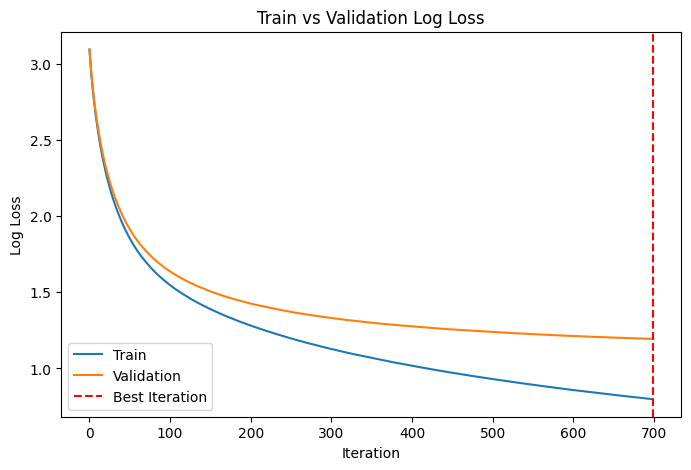

In [20]:
import matplotlib.pyplot as plt 

# Sauvegarde pendant ou après ton entraînement
plt.figure(figsize=(8,5))
plt.plot(evals_result['train']['mlogloss'], label='Train')
plt.plot(evals_result['eval']['mlogloss'], label='Validation')
plt.axvline(x=bst.best_iteration, color='red', linestyle='--', label='Best Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Train vs Validation Log Loss')
plt.legend()
plt.show()

In [21]:
y_pred_proba = bst.predict(d_train)                   # Probabilités pour chaque classe
y_pred = np.argmax(y_pred_proba, axis=1)  
acc = accuracy_score(y_train, y_pred)
acc

[11:35:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



0.7904982735954001


✅ Accuracy (Validation): 0.6006


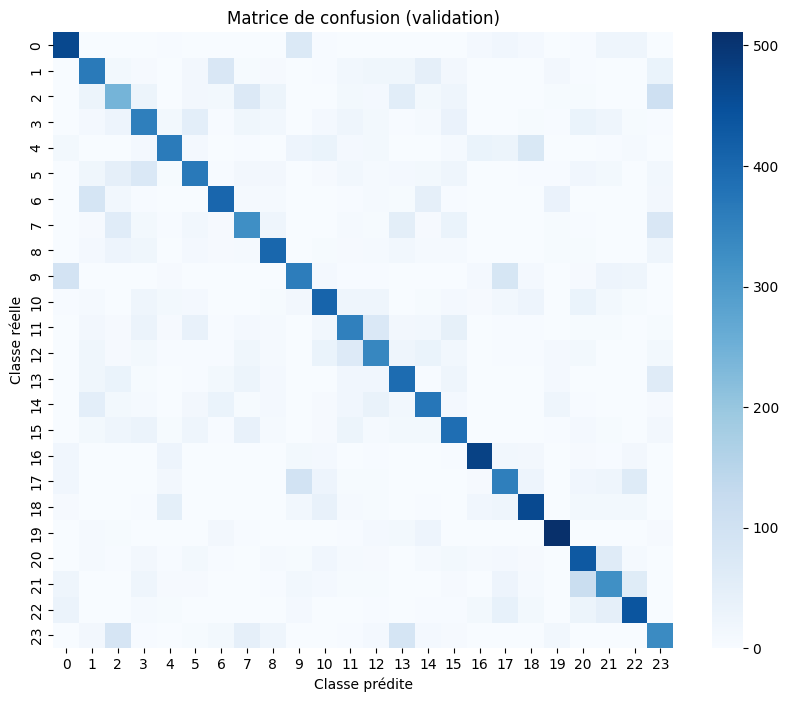


📊 Rapport de classification :
              precision    recall  f1-score   support

           0      0.692     0.737     0.714       631
           1      0.530     0.555     0.542       660
           2      0.400     0.368     0.383       660
           3      0.527     0.543     0.535       657
           4      0.695     0.563     0.622       647
           5      0.612     0.547     0.578       674
           6      0.681     0.628     0.653       645
           7      0.536     0.506     0.520       640
           8      0.684     0.707     0.695       570
           9      0.569     0.562     0.566       640
          10      0.632     0.628     0.630       650
          11      0.552     0.539     0.545       657
          12      0.536     0.543     0.540       626
          13      0.541     0.608     0.572       645
          14      0.588     0.591     0.590       629
          15      0.579     0.614     0.596       634
          16      0.816     0.788     0.802       

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === PRÉDICTIONS ===
y_pred_proba = bst.predict(d_valid)                   # Probabilités pour chaque classe
y_pred = np.argmax(y_pred_proba, axis=1)              # Classe prédite la plus probable

# === MÉTRIQUES DE BASE ===
acc = accuracy_score(y_valid, y_pred)
print(f"\n✅ Accuracy (Validation): {acc:.4f}")

# === MATRICE DE CONFUSION ===
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title("Matrice de confusion (validation)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

# === RAPPORT DÉTAILLÉ ===
print("\n📊 Rapport de classification :")
print(classification_report(y_valid, y_pred, digits=3))


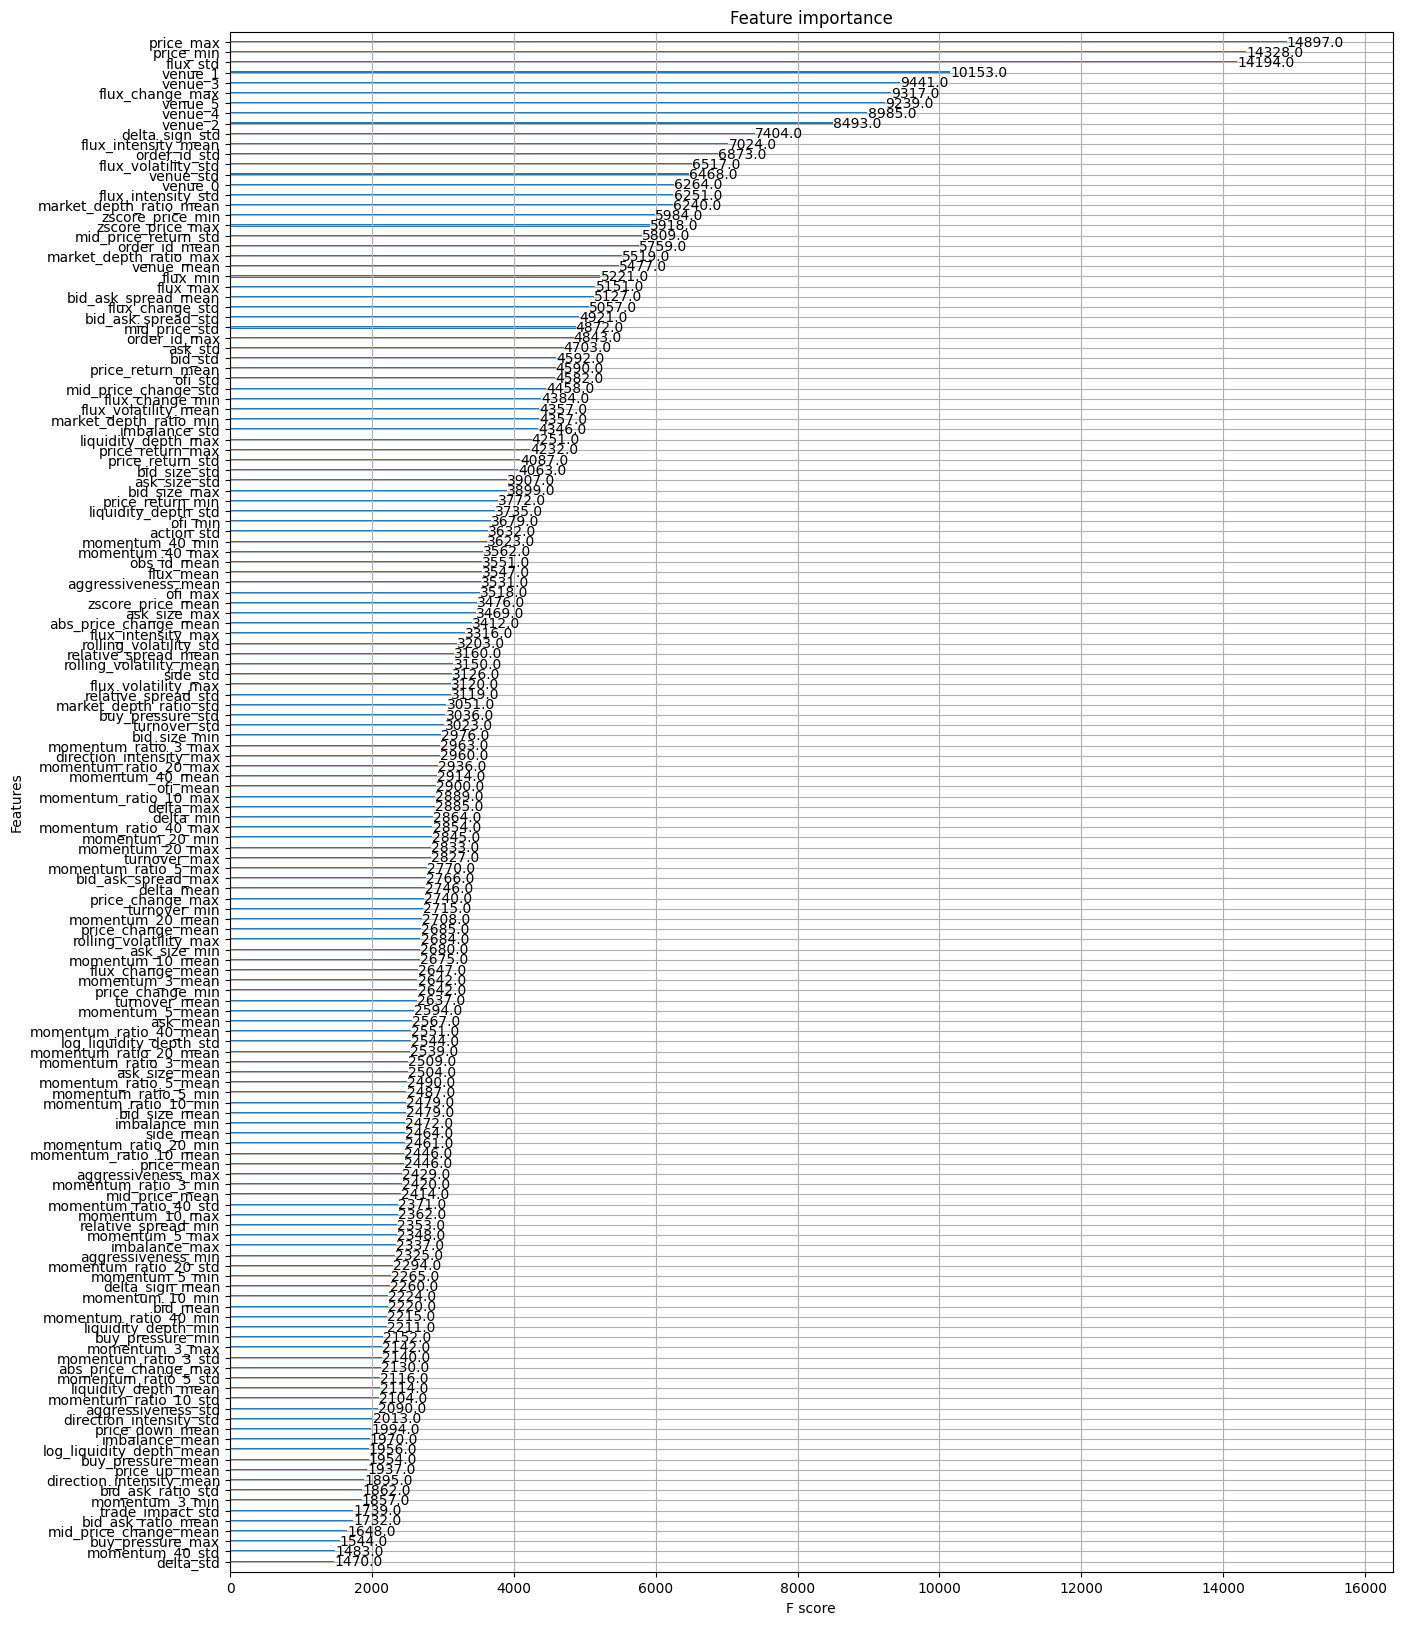

In [14]:
import matplotlib.pyplot as plt 

xgb.plot_importance(bst, max_num_features=150)
fig = plt.gcf()
fig.set_size_inches(15, 20)

In [28]:
import re

def rank_columns_by_importance(dico):
    """
    Trie les colonnes racines par importance maximale et retourne un dictionnaire :
    {colonne: (rang, somme_importances)}.
    Rang 1 = colonne la plus importante.
    """
    pattern = re.compile(r"(_mean|_std|_min|_max|_\d+)$")
    col_dict = {}

    # Accumuler les valeurs et garder la valeur max pour le ranking
    for col, val in dico.items():
        col_clean = pattern.sub("", col)  # enlève le suffixe
        if col_clean not in col_dict:
            col_dict[col_clean] = {"sum": 0.0, "max": 0.0}
        col_dict[col_clean]["sum"] += val
        if val > col_dict[col_clean]["max"]:
            col_dict[col_clean]["max"] = val

    # Trier par valeur maximale décroissante
    sorted_cols = sorted(col_dict.items(), key=lambda item: item[1]["max"], reverse=True)

    # Construire le dictionnaire final avec (rang, somme)
    ranked_cols = {
        col: (rank + 1, round(data["sum"], 4))  # arrondi pour lisibilité
        for rank, (col, data) in enumerate(sorted_cols)
    }

    return ranked_cols


In [29]:
# Récupérer importances des features
importance = bst.get_score(importance_type='weight')
col_ranked  = rank_columns_by_importance(importance)
col_ranked

{'price': (1, 31753.0),
 'flux': (2, 25288.0),
 'flux_change': (3, 18457.0),
 'venue': (4, 54941.0),
 'delta_sign': (5, 7752.0),
 'flux_intensity': (6, 13655.0),
 'order_id': (7, 15085.0),
 'market_depth_ratio': (8, 15274.0),
 'flux_volatility': (9, 10697.0),
 'mid_price_return': (10, 5227.0),
 'zscore_price': (11, 11596.0),
 'bid_ask_spread': (12, 11899.0),
 'mid_price': (13, 7752.0),
 'ofi': (14, 10524.0),
 'mid_price_change': (15, 6218.0),
 'liquidity_depth': (16, 9579.0),
 'imbalance': (17, 8012.0),
 'bid': (18, 5462.0),
 'ask': (19, 7224.0),
 'momentum_40': (20, 9095.0),
 'price_return': (21, 11350.0),
 'abs_price_change': (22, 6140.0),
 'bid_size': (23, 9741.0),
 'rolling_volatility': (24, 7904.0),
 'action': (25, 6525.0),
 'price_change': (26, 8060.0),
 'ask_size': (27, 8977.0),
 'delta': (28, 7816.0),
 'momentum_20': (29, 7757.0),
 'turnover': (30, 8117.0),
 'direction_intensity': (31, 5186.0),
 'relative_spread': (32, 7546.0),
 'liquidity_ratio': (33, 6788.0),
 'aggressiveness

{'price': 1,
 'flux': 2,
 'venue': 3,
 'flux_change': 4,
 'delta_sign': 5,
 'flux_intensity': 6,
 'order_id': 7,
 'flux_volatility': 8,
 'market_depth_ratio': 9,
 'zscore_price': 10,
 'mid_price_return': 11,
 'bid_ask_spread': 12,
 'mid_price': 13,
 'ask': 14,
 'bid': 15,
 'price_return': 16,
 'ofi': 17,
 'mid_price_change': 18,
 'imbalance': 19,
 'liquidity_depth': 20,
 'bid_size': 21,
 'ask_size': 22,
 'action': 23,
 'momentum_40': 24,
 'obs_id': 25,
 'aggressiveness': 26,
 'abs_price_change': 27,
 'rolling_volatility': 28,
 'relative_spread': 29,
 'side': 30,
 'buy_pressure': 31,
 'turnover': 32,
 'momentum_ratio_3': 33,
 'direction_intensity': 34,
 'momentum_ratio_20': 35,
 'momentum_ratio_10': 36,
 'delta': 37,
 'momentum_ratio_40': 38,
 'momentum_20': 39,
 'momentum_ratio_5': 40,
 'price_change': 41,
 'momentum_10': 42,
 'momentum_3': 43,
 'momentum_5': 44,
 'log_liquidity_depth': 45,
 'price_down': 46,
 'price_up': 47,
 'bid_ask_ratio': 48,
 'trade_impact': 49,
 'liquidity_ratio': 50,
 'sell_pressure': 51,
 'trade_flux_ratio': 52,
 'trade': 53,
 'pressure_diff': 54,
 'normalized_imbalance': 55}

In [17]:
# === CONSTRUCTION DU DMATRIX TEST ===

X_test_agg_df = summarize_by_obs(X_test)
d_test = xgb.DMatrix(X_test_agg_df.replace({0: np.nan}))

# === PRÉDICTION SUR LE TEST ===
y_test_proba = bst.predict(d_test)       # Probabilités pour chaque classe
y_test_pred = np.argmax(y_test_proba, axis=1)  # Classe prédite = argmax

In [25]:
df_test_fin = pd.DataFrame({"eqt_code_cat":y_test_pred})
df_test_fin.to_csv('solution_xgb_full_param_tuned.csv')
print(f"✅ Prédictions terminées : {len(y_test_pred)} observations.")

# Optionnel : afficher les 10 premières
print("Exemples de classes prédites :", y_test_pred[:10])


✅ Prédictions terminées : 81600 observations.
Exemples de classes prédites : [ 7  3  6  6 22  7  4  9 19 15]
